The second half of this notebook is what I use primarily in my analysis. The first half is informative, but wasn't used within the presentation/conclusion. 

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(42)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from tqdm import tqdm_notebook
from itertools import product

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split



In [301]:
df = pd.read_csv('df.csv') #Read in dataframe
df['Date'] = pd.to_datetime(df['Date'])

ts = df[['Date', 'Battery Electric Vehicle (BEV) Count']] #Dataframe for time series

## Modelling - Time Series Analysis
This will be the model I use within my presentation

Either I can use the total count and look at how that increases over time, but rather I will use the month on month change of EV's within Washington

In [302]:
ts.head()

,Date,Battery Electric Vehicle (BEV) Count
0,2017-01-31,14738
1,2017-02-28,15206
2,2017-03-31,15596
3,2017-04-30,16104
4,2017-05-31,16569


In [303]:
#Exponential Moving Averages
#https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

# Smoothing factor - 0.1
ts['EMA_0.1'] = ts['Battery Electric Vehicle (BEV) Count'].ewm(alpha=0.1, adjust=False).mean()
# Smoothing factor  - 0.3
ts['EMA_0.3'] = ts['Battery Electric Vehicle (BEV) Count'].ewm(alpha=0.3, adjust=False).mean()

/var/folders/v1/kyy1qs715rbg2rqbmr3z3rb40000gn/T/ipykernel_2880/2784374985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['EMA_0.1'] = ts['Battery Electric Vehicle (BEV) Count'].ewm(alpha=0.1, adjust=False).mean()
/var/folders/v1/kyy1qs715rbg2rqbmr3z3rb40000gn/T/ipykernel_2880/2784374985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['EMA_0.3'] = ts['Battery Electric Vehicle (BEV) Count'].ewm(alpha=0.3, adjust=False).mean()


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90')])

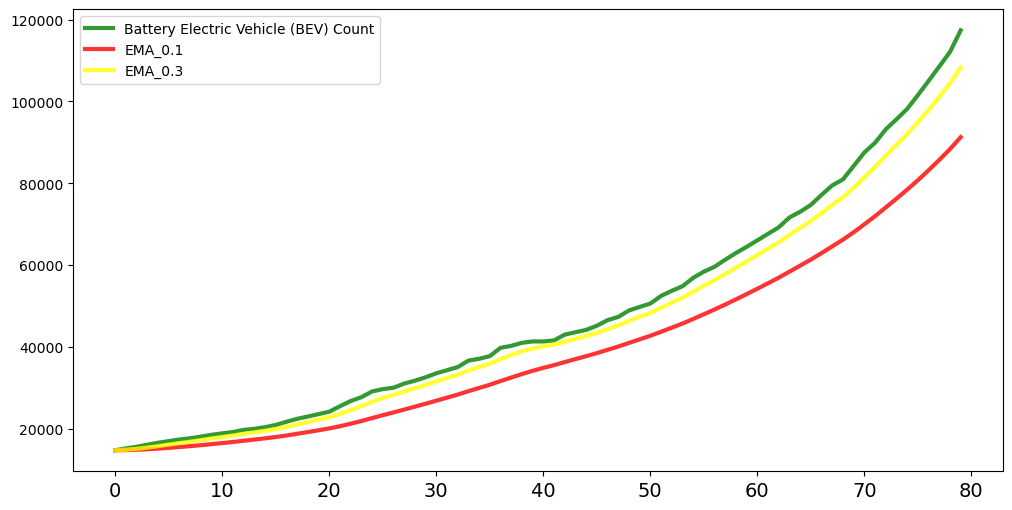

In [304]:
#Plotting above
colors = ['green', 'red', 'yellow']
ts[['Battery Electric Vehicle (BEV) Count', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)
plt.xticks(fontsize=14)

In [305]:
#New dataframe for month on month BEV's added
ts2 = df[['Date', 'New BEV Added']]
ts2 = ts2.drop(0)
ts2.head()

,Date,New BEV Added
1,2017-02-28,468.0
2,2017-03-31,390.0
3,2017-04-30,508.0
4,2017-05-31,465.0
5,2017-06-30,417.0


In [306]:
# Smoothing factor - 0.1
ts2['EMA_0.1'] = ts2['New BEV Added'].ewm(alpha=0.1, adjust=False).mean()
# Smoothing factor  - 0.3
ts2['EMA_0.3'] = ts2['New BEV Added'].ewm(alpha=0.3, adjust=False).mean()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90')])

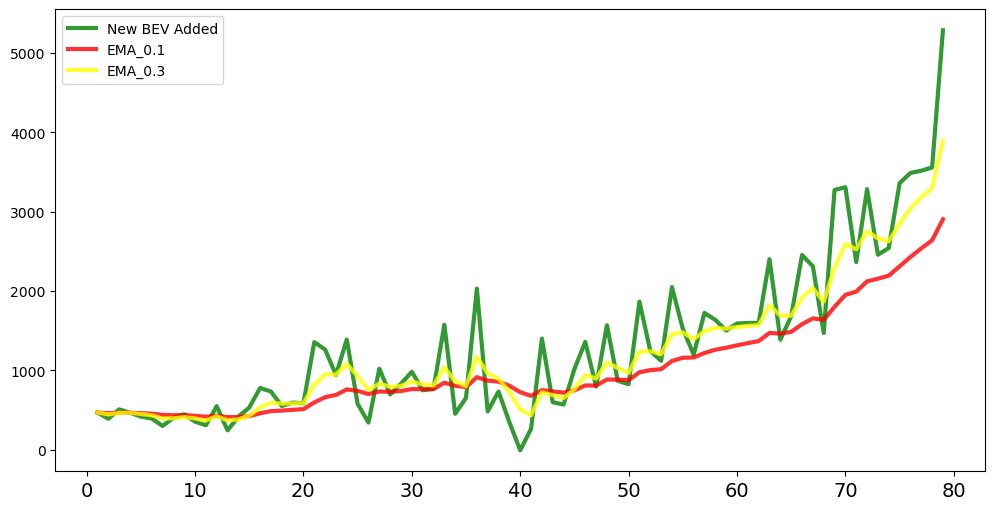

In [307]:
#Plot above
colors = ['green', 'red', 'yellow']
ts2[['New BEV Added', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)
plt.xticks(fontsize=14)

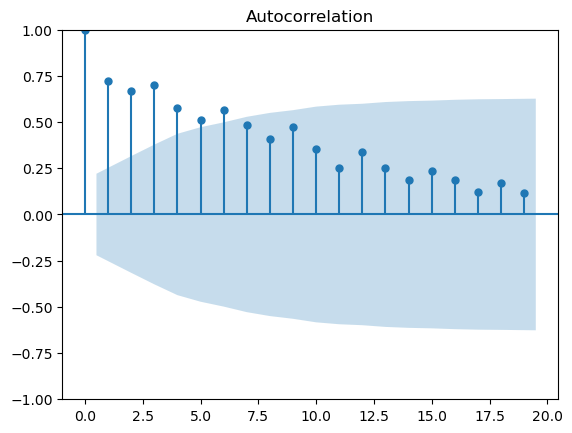

In [308]:
#ACF
plot_acf(ts2['New BEV Added'])
plt.show()

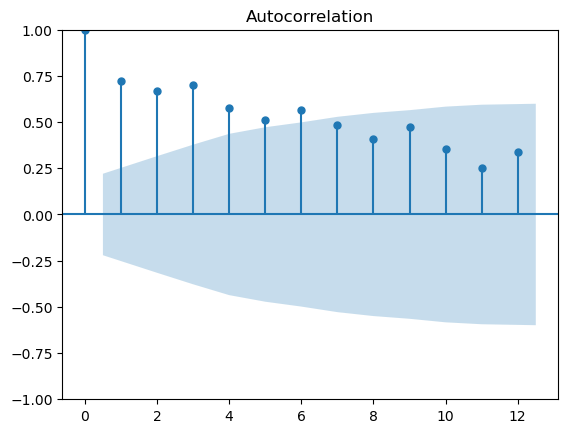

In [309]:
plot_acf(ts2['New BEV Added'], lags = 12)
plt.show()

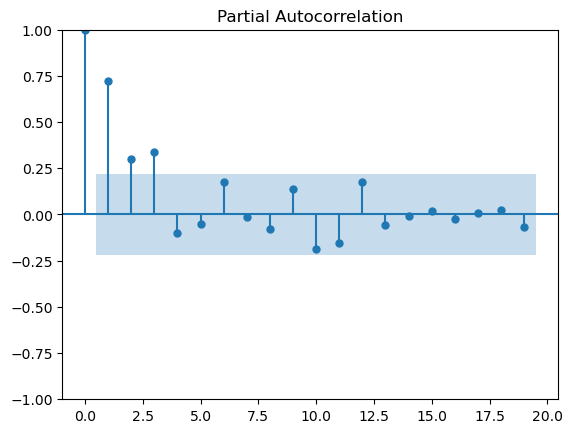

In [310]:
#PACF
plot_pacf(ts2['New BEV Added'])
plt.show()

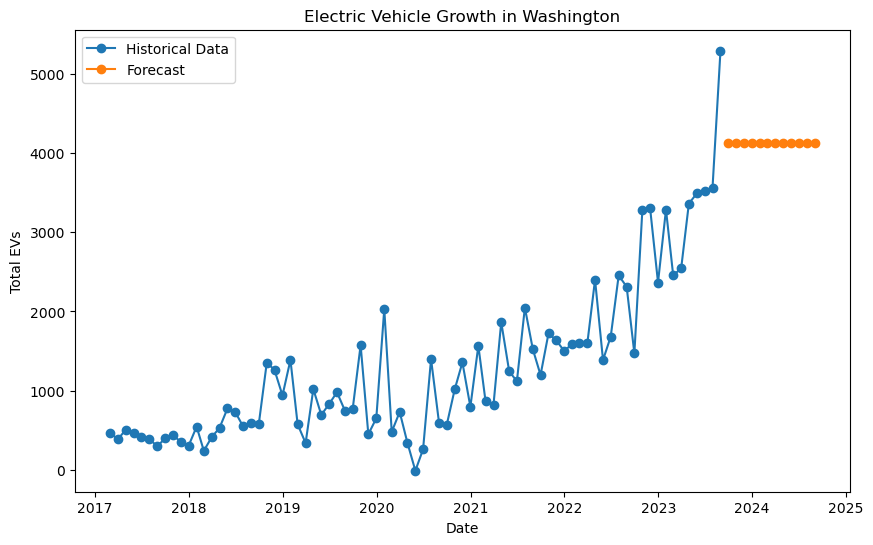

Forecasted Values for the Next 12 Months:
80    4122.427778
81    4122.427778
82    4122.427778
83    4122.427778
84    4122.427778
85    4122.427778
86    4122.427778
87    4122.427778
88    4122.427778
89    4122.427778
90    4122.427778
91    4122.427778
dtype: float64


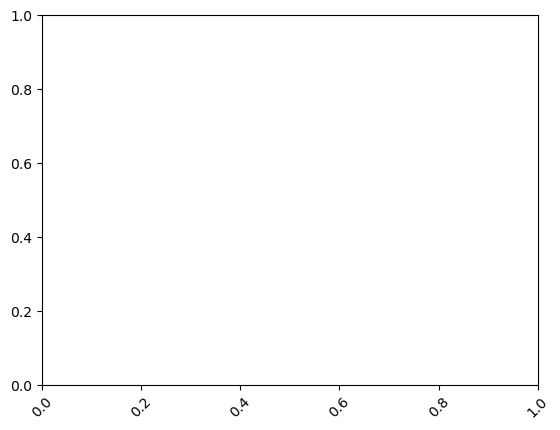

In [311]:
#Trying something. May work may not

ts2['Date'] = pd.to_datetime(ts2['Date'])

# Choose the best values for 'seasonal' and 'trend' based on data analysis and domain knowledge.
model = ExponentialSmoothing(ts2['New BEV Added'], seasonal_periods=12)
model_fit = model.fit()

# Step 5: Model Evaluation
# Use the fitted model to forecast and evaluate its performance
forecast = model_fit.forecast(12)  # Forecast the next 12 months

# Plot the historical data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts2['Date'], ts2['New BEV Added'], label='Historical Data', marker='o')
plt.plot(pd.date_range(start=ts2['Date'].iloc[-1], periods=13, freq='M')[1:], forecast, label='Forecast', marker='o')
plt.xlabel('Date')
plt.ylabel('Total EVs')
plt.title('Electric Vehicle Growth in Washington')
plt.legend()
plt.show()
plt.xticks(rotation = 45)

# Step 6: Future Projections
# The 'forecast' variable now contains the forecasted values for the next 12 months
print("Forecasted Values for the Next 12 Months:")
print(forecast)

In [312]:
#Checking column types
ts2.dtypes

Date             datetime64[ns]
New BEV Added           float64
EMA_0.1                 float64
EMA_0.3                 float64
dtype: object

### Multivariate Time Series Forecasting using VAR

Method for below refrenced from following link: https://www.youtube.com/watch?v=4jv1NGlAc_0

In [313]:
#Setting date as index
df.set_index('Date', inplace=True)
df.head()

,Unnamed: 0,Plug-In Hybrid Electric Vehicle (PHEV) Count,Battery Electric Vehicle (BEV) Count,Electric Vehicle (EV) Total,BEV Percent Change,CPI,PPI,CCI,48_month_loan,60_month_loan,s&p,gdp,New BEV Added
Date,,,,,,,,,,,,,
2017-01-31,0,7687,14738,22425,NaN,242.839,190.7,101.3867,4.45,4.05,2329.91,NaN,NaN
2017-02-28,1,7888,15206,23094,3.175465,243.603,191.6,101.3742,4.52,4.21,2366.82,NaN,468.0
2017-03-31,2,8092,15596,23688,2.564777,243.801,191.5,101.3430,4.52,4.21,2359.31,NaN,390.0
2017-04-30,3,8286,16104,24390,3.257245,244.524,193.0,101.3027,4.52,4.21,2395.35,NaN,508.0
2017-05-31,4,8497,16569,25066,2.887481,244.733,192.8,101.2303,4.67,4.24,2433.99,NaN,465.0


In [314]:
df = df.drop(columns = ['Unnamed: 0', 'gdp'])

In [315]:
df.head()

,Plug-In Hybrid Electric Vehicle (PHEV) Count,Battery Electric Vehicle (BEV) Count,Electric Vehicle (EV) Total,BEV Percent Change,CPI,PPI,CCI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,,,,,,,
2017-01-31,7687,14738,22425,NaN,242.839,190.7,101.3867,4.45,4.05,2329.91,NaN
2017-02-28,7888,15206,23094,3.175465,243.603,191.6,101.3742,4.52,4.21,2366.82,468.0
2017-03-31,8092,15596,23688,2.564777,243.801,191.5,101.3430,4.52,4.21,2359.31,390.0
2017-04-30,8286,16104,24390,3.257245,244.524,193.0,101.3027,4.52,4.21,2395.35,508.0
2017-05-31,8497,16569,25066,2.887481,244.733,192.8,101.2303,4.67,4.24,2433.99,465.0


In [316]:
#Only keeping relevant columns
df = df.drop(columns = ['Plug-In Hybrid Electric Vehicle (PHEV) Count', 'Battery Electric Vehicle (BEV) Count', 'Electric Vehicle (EV) Total', 'BEV Percent Change'])
df.head()

,CPI,PPI,CCI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,,,
2017-01-31,242.839,190.7,101.3867,4.45,4.05,2329.91,NaN
2017-02-28,243.603,191.6,101.3742,4.52,4.21,2366.82,468.0
2017-03-31,243.801,191.5,101.3430,4.52,4.21,2359.31,390.0
2017-04-30,244.524,193.0,101.3027,4.52,4.21,2395.35,508.0
2017-05-31,244.733,192.8,101.2303,4.67,4.24,2433.99,465.0


In [317]:
#Dropping nulls
df = df.dropna()
df.head()

,CPI,PPI,CCI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,,,
2017-02-28,243.603,191.6,101.3742,4.52,4.21,2366.82,468.0
2017-03-31,243.801,191.5,101.3430,4.52,4.21,2359.31,390.0
2017-04-30,244.524,193.0,101.3027,4.52,4.21,2395.35,508.0
2017-05-31,244.733,192.8,101.2303,4.67,4.24,2433.99,465.0
2017-06-30,244.955,193.6,101.1226,4.67,4.24,2454.10,417.0


Will be looking to project New BEV's added month to month. Gathered various economic indicators which run parallel in timing to BEV's added at end of month. 

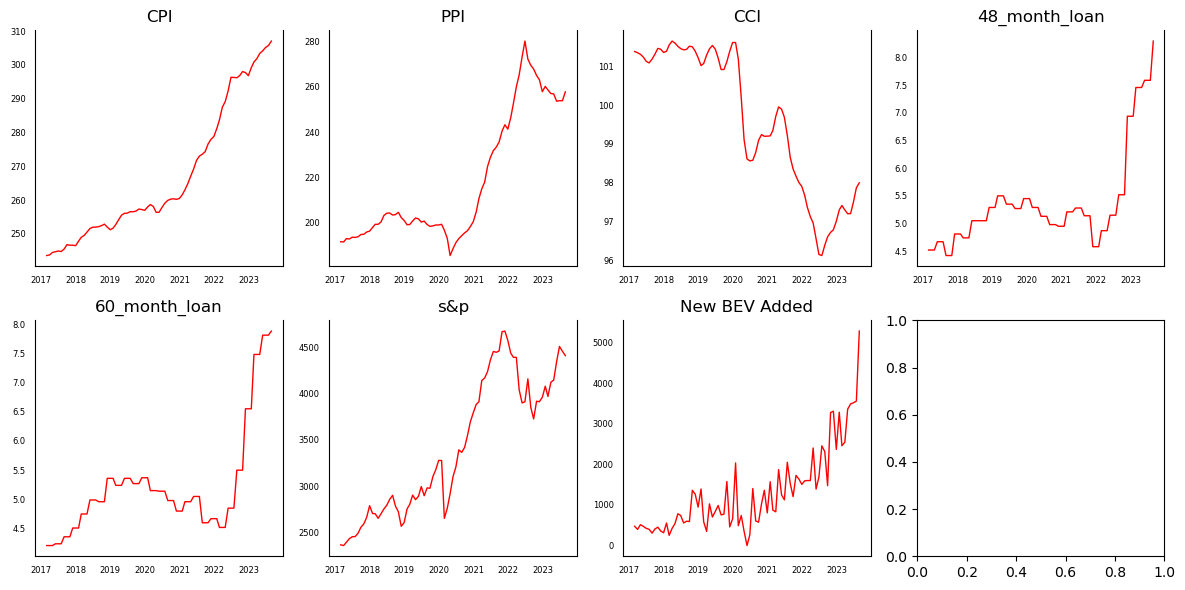

In [318]:
#Plots of all our variables

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
for i, ax in enumerate(axes.flatten()[:min(len(df.columns), 7)]):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [319]:
#Augmented Dickey Fuller test for stationarity
#Differencing until p-values are less than 0.05

#CPI Diff twice
ad_fuller_result_1 = adfuller(df['CPI'].diff().diff()[2:])

print('CPI')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

#PPI Diff once
ad_fuller_result_2 = adfuller(df['PPI'].diff()[1:])

print('PPI')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

#CCI Diff once
ad_fuller_result_3 = adfuller(df['CCI'].diff()[1:])

print('CCI')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

#48 month loan Diff once
ad_fuller_result_4 = adfuller(df['48_month_loan'].diff()[1:])

print('48_month_loan')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

#60 month loan Diff twice
ad_fuller_result_5 = adfuller(df['60_month_loan'].diff().diff()[2:])

print('60_month_loan')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

#s&p Diff once
ad_fuller_result_6 = adfuller(df['s&p'].diff()[1:])

print('s&p')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')

#New BEV Added Diff once 
ad_fuller_result_7 = adfuller(df['New BEV Added'].diff()[1:])

print('New BEV Added')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

CPI
ADF Statistic: -6.579818750933214
p-value: 7.56352968333538e-09
PPI
ADF Statistic: -5.033873676515983
p-value: 1.901059865377293e-05
CCI
ADF Statistic: -3.0526353439776877
p-value: 0.030262800961319614
48_month_loan
ADF Statistic: -3.3234088580863648
p-value: 0.013863978480976157
60_month_loan
ADF Statistic: -19.379349573820054
p-value: 0.0
s&p
ADF Statistic: -8.045791757991365
p-value: 1.7961217651752984e-12
New BEV Added
ADF Statistic: -13.333369227563121
p-value: 6.120287974698235e-25


In [320]:
#Granger causality test to check for causality between feature variables and target
#Checking to see if pvalue is less than 0.05 
granger_cpi = grangercausalitytests(df[['CPI', 'New BEV Added']], 4)
#p < 0.05


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2597  , p=0.0087  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=7.5501  , p=0.0060  , df=1
likelihood ratio test: chi2=7.2067  , p=0.0073  , df=1
parameter F test:         F=7.2597  , p=0.0087  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8550  , p=0.0641  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=6.1065  , p=0.0472  , df=2
likelihood ratio test: chi2=5.8764  , p=0.0530  , df=2
parameter F test:         F=2.8550  , p=0.0641  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0211  , p=0.1190  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=6.6785  , p=0.0829  , df=3
likelihood ratio test: chi2=6.4012  , p=0.0936  , df=3
parameter F test:         F=2.0211  , p=0.1190  , df_denom=69, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3555  , p=0.2589  , df_d

In [321]:
granger_ppi = grangercausalitytests(df[['PPI', 'New BEV Added']], 10)
#pvalue > 0.05


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9985  , p=0.1616  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=2.0784  , p=0.1494  , df=1
likelihood ratio test: chi2=2.0512  , p=0.1521  , df=1
parameter F test:         F=1.9985  , p=0.1616  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5310  , p=0.5903  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=1.1357  , p=0.5668  , df=2
likelihood ratio test: chi2=1.1274  , p=0.5691  , df=2
parameter F test:         F=0.5310  , p=0.5903  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5030  , p=0.6815  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=1.6621  , p=0.6454  , df=3
likelihood ratio test: chi2=1.6442  , p=0.6494  , df=3
parameter F test:         F=0.5030  , p=0.6815  , df_denom=69, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8869  , p=0.4768  , df_d

In [322]:
granger_cci = grangercausalitytests(df[['CCI', 'New BEV Added']], 10)
#pvalue > 0.05


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9171  , p=0.3413  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=0.9538  , p=0.3287  , df=1
likelihood ratio test: chi2=0.9480  , p=0.3302  , df=1
parameter F test:         F=0.9171  , p=0.3413  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8313  , p=0.1676  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=3.9169  , p=0.1411  , df=2
likelihood ratio test: chi2=3.8205  , p=0.1480  , df=2
parameter F test:         F=1.8313  , p=0.1676  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6680  , p=0.5745  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=2.2074  , p=0.5305  , df=3
likelihood ratio test: chi2=2.1759  , p=0.5367  , df=3
parameter F test:         F=0.6680  , p=0.5745  , df_denom=69, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8617  , p=0.4917  , df_d

In [323]:
granger_48_month_loan = grangercausalitytests(df[['48_month_loan', 'New BEV Added']], 4)
#p < 0.05


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6839 , p=0.0001  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=17.3513 , p=0.0000  , df=1
likelihood ratio test: chi2=15.6670 , p=0.0001  , df=1
parameter F test:         F=16.6839 , p=0.0001  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.0958  , p=0.0003  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=19.4549 , p=0.0001  , df=2
likelihood ratio test: chi2=17.3458 , p=0.0002  , df=2
parameter F test:         F=9.0958  , p=0.0003  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3013  , p=0.0008  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=20.8218 , p=0.0001  , df=3
likelihood ratio test: chi2=18.4025 , p=0.0004  , df=3
parameter F test:         F=6.3013  , p=0.0008  , df_denom=69, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5859  , p=0.0105  , df_d

In [324]:
granger_60_month_loan = grangercausalitytests(df[['60_month_loan', 'New BEV Added']], 4)
#p < 0.05


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2910 , p=0.0003  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=14.8626 , p=0.0001  , df=1
likelihood ratio test: chi2=13.6042 , p=0.0002  , df=1
parameter F test:         F=14.2910 , p=0.0003  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.0444  , p=0.0003  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=19.3450 , p=0.0001  , df=2
likelihood ratio test: chi2=17.2580 , p=0.0002  , df=2
parameter F test:         F=9.0444  , p=0.0003  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1360  , p=0.0009  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=20.2754 , p=0.0001  , df=3
likelihood ratio test: chi2=17.9725 , p=0.0004  , df=3
parameter F test:         F=6.1360  , p=0.0009  , df_denom=69, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2247  , p=0.0757  , df_d

In [325]:
granger_snp = grangercausalitytests(df[['s&p', 'New BEV Added']], 4)
#2nd lag, p<0.5


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6470  , p=0.1079  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=2.7529  , p=0.0971  , df=1
likelihood ratio test: chi2=2.7054  , p=0.1000  , df=1
parameter F test:         F=2.6470  , p=0.1079  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2469  , p=0.0006  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=17.6391 , p=0.0001  , df=2
likelihood ratio test: chi2=15.8825 , p=0.0004  , df=2
parameter F test:         F=8.2469  , p=0.0006  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7134  , p=0.0015  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=18.8792 , p=0.0003  , df=3
likelihood ratio test: chi2=16.8622 , p=0.0008  , df=3
parameter F test:         F=5.7134  , p=0.0015  , df_denom=69, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3485  , p=0.0035  , df_d

In [326]:
df.head()

,CPI,PPI,CCI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,,,
2017-02-28,243.603,191.6,101.3742,4.52,4.21,2366.82,468.0
2017-03-31,243.801,191.5,101.3430,4.52,4.21,2359.31,390.0
2017-04-30,244.524,193.0,101.3027,4.52,4.21,2395.35,508.0
2017-05-31,244.733,192.8,101.2303,4.67,4.24,2433.99,465.0
2017-06-30,244.955,193.6,101.1226,4.67,4.24,2454.10,417.0


In [327]:
#Going to make new df based on the columns which show causality
gg = df[['CPI', '48_month_loan', '60_month_loan', 's&p', 'New BEV Added']]
gg.head()

,CPI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,
2017-02-28,243.603,4.52,4.21,2366.82,468.0
2017-03-31,243.801,4.52,4.21,2359.31,390.0
2017-04-30,244.524,4.52,4.21,2395.35,508.0
2017-05-31,244.733,4.67,4.24,2433.99,465.0
2017-06-30,244.955,4.67,4.24,2454.10,417.0


In [328]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(gg[['CPI', '48_month_loan', '60_month_loan', 's&p']],
                                                    gg['New BEV Added'],
                                                    test_size = 0.2,
                                                    shuffle = False)

In [329]:
#Creating train df and test df. No shuffle needed as time series
train_df=gg[:-16]
test_df=gg[-16:]
train_df_copy = train_df

In [330]:
#Going to include features with respective differences from ADF test
#CPI and 60 month loan need to be differenced twice
train_df = train_df.diff()[1:]
train_df[['CPI', '60_month_loan']] = train_df[['CPI', '60_month_loan']].diff()[1:]

In [331]:
#Dropping row as has null values due to differencing
train_df = train_df.drop('2017-04-30', axis=0)
train_df.head()

,CPI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,
2017-03-31,NaN,0.00,NaN,-7.51,-78.0
2017-05-31,-0.514,0.15,0.03,38.64,-43.0
2017-06-30,0.013,0.00,-0.03,20.11,-48.0
2017-07-31,-0.391,0.00,0.00,2.12,-24.0
2017-08-31,0.902,-0.25,0.12,36.62,-94.0


In [332]:
#Dropping row 
train_df = train_df.drop('2017-03-31', axis=0)
train_df.head()

,CPI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,
2017-05-31,-0.514,0.15,0.03,38.64,-43.0
2017-06-30,0.013,0.00,-0.03,20.11,-48.0
2017-07-31,-0.391,0.00,0.00,2.12,-24.0
2017-08-31,0.902,-0.25,0.12,36.62,-94.0
2017-09-30,0.567,0.00,-0.12,64.16,101.0


In [333]:
#Fitting model to train df
model = VAR(train_df)

/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [334]:
sorted_order=model.select_order(maxlags=9)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       14.34       14.53   1.695e+06       14.42
1       14.16       15.30   1.424e+06       14.60
2       13.89       15.97   1.115e+06       14.69
3       13.97       17.00   1.299e+06       15.13
4       13.78       17.75   1.248e+06       15.30
5       13.13       18.06   8.565e+05       15.02
6       12.85       18.73   1.015e+06       15.10
7       11.80       18.62   7.537e+05       14.41
8       10.44       18.20   7.239e+05       13.40
9      3.392*      12.10*      9889.*      6.722*
-------------------------------------------------


In [336]:
var_model = VARMAX(train_df_copy, order=(9,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                   Statespace Model Results                                                  
Dep. Variable:     ['CPI', '48_month_loan', '60_month_loan', 's&p', 'New BEV Added']   No. Observations:                   63
Model:                                                                        VAR(9)   Log Likelihood               -1369.252
                                                                         + intercept   AIC                           3228.504
Date:                                                               Sun, 05 Nov 2023   BIC                           3753.572
Time:                                                                       16:58:51   HQIC                          3435.015
Sample:                                                                   02-28-2017                                         
                                                                        - 04-30-2022                                  

In [354]:
#Forecasting predictions for the next 36 months
n_forecast = 36
predict = fitted_model.get_prediction(start=79, end=100)

predictions=predict.predicted_mean

In [355]:
predictions

,CPI,48_month_loan,60_month_loan,s&p,New BEV Added
2023-09-30,264.066894,2.415205,6.381215,3342.549204,1085.988950
2023-10-31,264.003474,2.399709,6.230865,3322.548129,1073.374107
2023-11-30,264.074370,2.409404,6.067958,3308.270407,1060.590814
2023-12-31,264.293720,2.420415,5.884241,3296.611649,1050.819231
2024-01-31,264.226307,2.438617,5.740736,3282.345030,1040.131719
2024-02-29,263.951958,2.465645,5.631931,3267.050512,1027.460109
2024-03-31,263.565544,2.497207,5.549488,3251.710952,1015.381736
2024-04-30,263.153339,2.534418,5.482507,3237.385352,1004.602154
2024-05-31,262.772995,2.577184,5.422253,3224.570790,994.216384
2024-06-30,262.404016,2.621045,5.368898,3212.410917,984.515192


In [347]:
len(test_df)

16

In [343]:
#predictions.to_csv('../Modelling/predictions.csv')

In [344]:
test_df

,CPI,48_month_loan,60_month_loan,s&p,New BEV Added
Date,,,,,
2022-05-31,292.296,5.15,4.85,3898.95,1387.0
2022-06-30,296.311,5.15,4.85,3911.73,1683.0
2022-07-31,296.276,5.15,4.85,4158.56,2454.0
2022-08-31,296.171,5.52,5.50,3850.52,2312.0
2022-09-30,296.808,5.52,5.50,3726.05,1471.0
2022-10-31,298.012,5.52,5.50,3917.49,3275.0
2022-11-30,297.711,6.94,6.55,3912.38,3309.0
2022-12-31,296.797,6.94,6.55,3960.66,2365.0
2023-01-31,299.170,6.94,6.55,4079.68,3285.0
